### 1. Load dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm
import os
import math

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q /content/drive/MyDrive/thesis/pendulum/regressor_data.zip -d .

In [3]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)

        self.dataset = dataset
        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        data = self.transforms(pil_img)[:3]
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [4]:
dataset_train = Synthetic('regressor_data', "train")
dataset_test = Synthetic('regressor_data', "test")
dataset_train[0]['img'].shape

torch.Size([3, 96, 96])

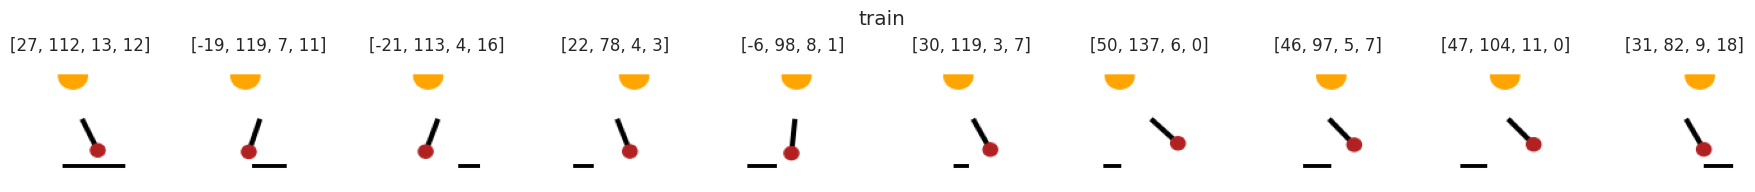

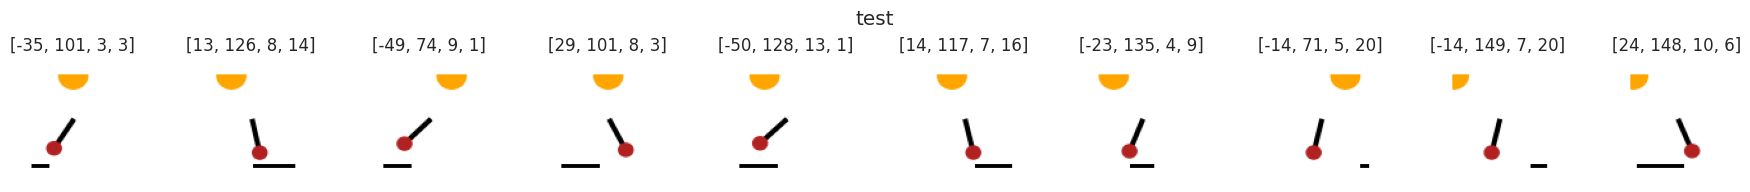

In [5]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test'], [dataset_train, dataset_test]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

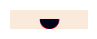

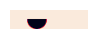

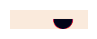

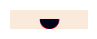

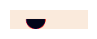

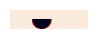

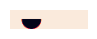

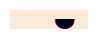

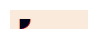

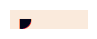

torch.Size([24, 96])


In [6]:
for i in range(10):
    sample = dataset[i]
    x = sample['img'][1, :24]
    plt.figure(figsize=(1, 2))
    plt.imshow(x)
    plt.axis('off');
    plt.show()
print(x.shape)

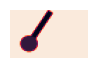

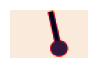

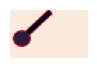

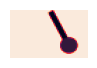

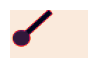

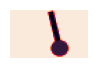

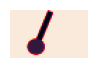

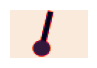

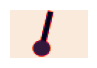

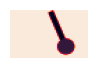

torch.Size([35, 56])


In [7]:
for i in range(10):
    sample = dataset[i]
    x = sample['img'][1, 45:80, 20:-20]
    plt.figure(figsize=(1, 2))
    plt.imshow(x)
    plt.axis('off');
    plt.show()
print(x.shape)

In [8]:
for i in range(10):
    sample = dataset[i]
    x = sample['img'][1, 83:85]
    plt.figure(figsize=(1, 2))
    plt.imshow(x)
    plt.axis('off');
    plt.show()
print(x.shape)

torch.Size([2, 96])


In [9]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### 2. Train Classifier

In [14]:
!pip install -q torchinfo
from torchinfo import summary

In [46]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun, pend, shade = x[:, 1, :24].unsqueeze(1), x[:, 1, 45:80, 20:-20].unsqueeze(1), x[:, 1, 83:85]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [47]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
regressor = PendulumRegressor().to(device)
summary(regressor, input_size=(1, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
PendulumRegressor                        [1, 4]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Flatten: 2-1                      [1, 2304]                 --
│    └─Linear: 2-2                       [1, 512]                  1,180,160
│    └─ReLU: 2-3                         [1, 512]                  --
│    └─Dropout: 2-4                      [1, 512]                  --
│    └─Linear: 2-5                       [1, 64]                   32,832
│    └─ReLU: 2-6                         [1, 64]                   --
│    └─Dropout: 2-7                      [1, 64]                   --
│    └─Linear: 2-8                       [1, 1]                    65
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-9                      [1, 1960]                 --
│    └─Linear: 2-10                      [1, 512]                  1,004,0

In [48]:
def plot_histories(histories, names):
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

def print_epoch(epoch, num_epochs, history, t):
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history['loss']['train'][-1]))
    print("  validation loss: \t{:.6f}".format(history['loss']['val'][-1]))
    print("  training accuracy: ", history['acc']['train'][-1] * 100)
    print("  validation accuracy: ", history['acc']['val'][-1] * 100)


def update_history(history, loss, acc, num_batches, mode):
    loss /= num_batches
    acc /= num_batches
    history['loss'][mode].append(loss)
    history['acc'][mode].append(acc)


def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    pred = model(X_batch) # (BS, 30)
    loss = criterion(pred, y_batch.float())

    current_loss += loss.detach().cpu().numpy()
    y_pred = pred.int()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred.cpu().numpy(), axis=0)
    return loss, current_loss, current_acc


def train(model, criterion, optimizer,
          train_batch_gen, val_batch_gen, num_epochs=40, history=None):
    if history is None:
        history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = np.zeros(4), np.zeros(4)
        start_time = time.time()

        model.train(True)
        for batch in train_batch_gen:
            loss, train_loss, train_acc = get_batch_loss(batch['img'], batch['label'], model, criterion, train_loss, train_acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        update_history(history, train_loss, train_acc, len(train_batch_gen), 'train')
        model.train(False)
        with torch.no_grad():
            for batch in val_batch_gen:
                _, val_loss, val_acc = get_batch_loss(batch['img'], batch['label'], model, criterion, val_loss, val_acc)

        update_history(history, val_loss, val_acc, len(val_batch_gen), 'val')
        print_epoch(epoch, num_epochs, history, time.time() - start_time)
    return history

In [52]:
# NN
criterion = nn.MSELoss()
device = f"cuda" if torch.cuda.is_available() else "cpu"
regressor = PendulumRegressor().to(device)
optimizer = torch.optim.AdamW(regressor.parameters(), lr=1e-3)

history = defaultdict(lambda: defaultdict(list))
history = train(
    regressor, criterion, optimizer,
    train_loader, test_loader, 10, history=history)

Epoch 10 of 10 took 84.321 s
  training loss: 	74.696656
  validation loss: 	1.573885
  training accuracy:  [12.07817492  2.74435903 25.08112021 25.47174521]
  validation accuracy:  [34.96340981 26.27076741 29.61827532 30.02373418]


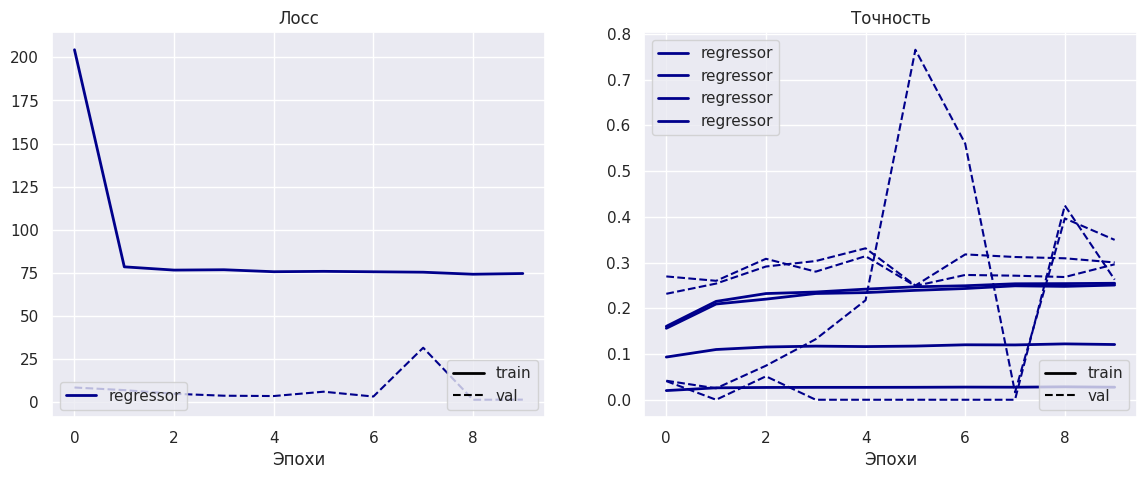

In [53]:
# NN
plot_histories([history], ['regressor'])

In [56]:
torch.save(regressor.state_dict(), '/content/drive/MyDrive/thesis/regressor.pth')

### 3. Inference

In [54]:
# test
batch = next(iter(test_loader))
ids = np.random.choice(len(batch['img']), 10, replace=False)
X_batch = batch['img'][ids].to(device)
y_batch = batch['label'][ids].to(device)
pred = regressor(X_batch) # (BS, 30)
y_pred = pred.int()

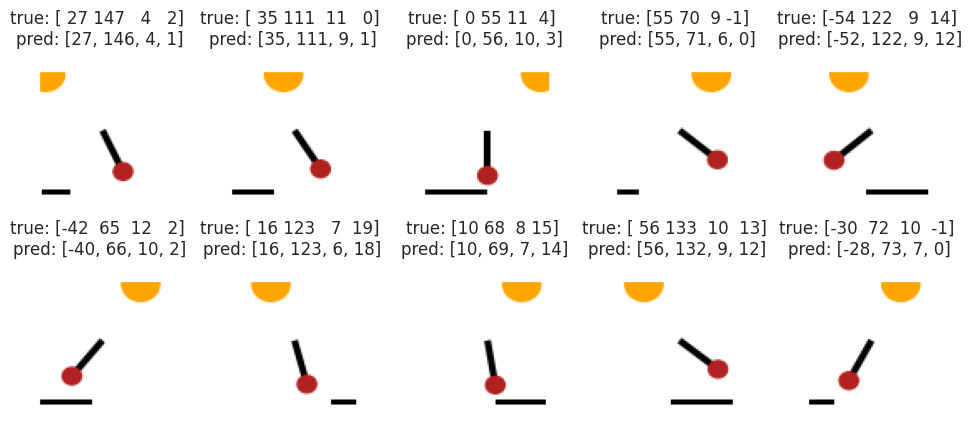

In [55]:
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
ax = ax.flatten()
for i, (x, pred, real) in enumerate(zip(X_batch, y_pred, y_batch)):
    ax[i].imshow(normalize(x.permute(1, 2, 0).cpu()))
    ax[i].axis('off')
    ax[i].set_title('true: ' + str(real.cpu().numpy()) + " \npred: " + str(pred.cpu().tolist()))